In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import meta_classifier_utils as utils

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report

In [ ]:
#case_report = pd.read_csv('results tf/classification_report_by_case.csv')
image_report = pd.read_csv('results tf/classification_report_by_image.csv')
#gt = pd.read_csv('patients/patient_gt.csv')

# Case Classification

In [ ]:
utils.dataframe_builder_case(image_report,case_report)

In [ ]:
data = pd.read_csv('results tf/metaclassifier_case_report.csv')
data.describe()

In [ ]:
X = data.loc[:, data.columns != 'Ground Truth']
X = X.loc[:, X.columns != 'Patient']
X = X.loc[:, X.columns != 'Classification']
y = data['Ground Truth']

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.3)

In [ ]:
my_imputer = SimpleImputer(strategy='constant',fill_value=56)
imputed_X_train_age = my_imputer.fit_transform(np.array(X_train['Age']).reshape(-1,1))
imputed_X_valid_age = my_imputer.transform(np.array(X_valid['Age']).reshape(-1,1))
X_train['Age'] = imputed_X_train_age
X_valid['Age'] = imputed_X_valid_age

In [ ]:
forest_model = RandomForestClassifier(n_estimators=100)
pipeline = Pipeline(steps=[('model',forest_model)])
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_valid)
print(classification_report(y_valid, preds))

In [ ]:
importance = forest_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
s = svm.SVC()
s.fit(X_train,y_train)
preds = s.predict(X_valid)
print(classification_report(y_valid, preds))

## Cross-Validation

In [ ]:
imputed_X_age = my_imputer.fit_transform(np.array(X['Age']).reshape(-1,1))
X['Age'] = imputed_X_age

In [ ]:
scores = cross_val_score(pipeline, X, y,cv=5,scoring='accuracy')
print('Accuracies: \n',scores)

# Image Classification

In [2]:
transfer = True

In [ ]:
i_v = []
for i in list(image_report['Image View']):
    if 'LCC' in i:
        i_v.append('LCC')
    elif 'LO' in i:
        i_v.append('LO')
    elif 'RCC' in i:
        i_v.append('RCC')
    else:
        i_v.append('RO')
image_report['Image View'] = i_v

In [ ]:
utils.mammary_features(image_report,transfer)

In [3]:
if transfer:
    report = pd.read_csv('results tf/metaclassifier_report.csv')
else:
    report = pd.read_csv('results f-s/metaclassifier_report.csv')

In [4]:
image_report = report.sample(n=len(report.index),axis=0,)

In [5]:
p = list(image_report['Patches'])
s = list(image_report['Suspicious'])
c = []
for i in range(len(p)):
    f = float("{:.2f}".format(s[i]/p[i]))
    c.append(f)

In [6]:
X = image_report.loc[:, image_report.columns != 'Ground Truth']
X = X.loc[:, X.columns != 'Patient']
X = X.loc[:, X.columns != 'Density']
X = X.loc[:, X.columns != 'Overlay']
X = X.loc[:, X.columns != 'Lesion']
X = X.loc[:, X.columns != 'Classification']
#X = X.loc[:, X.columns != 'Age']
X = X.loc[:, X.columns != 'Patches']
#X = X.loc[:, X.columns != 'Suspicious']
X = X.loc[:, X.columns != 'Image View']
#X = X.loc[:, X.columns != 'I_Skewness']
#X = X.loc[:, X.columns != 'Area Factor']
X['Ratio'] = c
y = image_report['Ground Truth']

In [7]:
my_imputer = SimpleImputer(strategy='constant',fill_value=56)
imputed_X = my_imputer.fit_transform(np.array(X['Age']).reshape(-1,1))
X['Age'] = imputed_X

In [8]:
#my_imputer = SimpleImputer(strategy='constant',fill_value=2)
#imputed_X = my_imputer.fit_transform(np.array(X['Density']).reshape(-1,1))
#X['Density'] = imputed_X

#my_imputer = SimpleImputer(missing_values=' NaN',strategy='constant',fill_value=2)
#imputed_X = my_imputer.fit_transform(np.array(X['Density']).reshape(-1,1))
#X['Density'] = imputed_X

#X = X.astype({'Density': 'float32'})

In [9]:
label_y = y.copy()
label_encoder = LabelEncoder()
label_y= label_encoder.fit_transform(y)

In [10]:
#oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
#oh_cols = pd.DataFrame(oh_encoder.fit_transform(np.array(X['Image View']).reshape(-1,1)))
#oh_cols.index = X.index
#num_X = X.drop('Image View', axis=1)
#oh_X= pd.concat([num_X, oh_cols], axis=1)
#X = oh_X.rename(columns={0: oh_encoder.categories_[0][0], 1: oh_encoder.categories_[0][1],2:oh_encoder.categories_[0][2],3:oh_encoder.categories_[0][3]})

In [11]:
X = X.astype({'Age': 'int32','I_Median': 'int32','I_Mode': 'int32'})

In [12]:
X1 = X.rename(columns={'Ratio':'Patches_Norm','Suspicious':'Patches_Sus'},inplace=False)

In [13]:
X1.head(20)

,Age,Area Factor,Patches_Sus,I_Mean,I_Std,I_Median,I_Mode,T_Entropy,I_Skewness,I_Kurtosis,Patches_Norm
321,56,39.8,8,174.96882,20.00056,181,185,4.12081,-1.55213,4.68908,0.04
319,56,31.9,6,182.15196,19.23552,180,177,4.26662,-0.41918,1.76569,0.05
58,54,15.5,27,100.54356,44.28632,98,103,4.81530,1.23731,1.81340,0.44
379,51,35.8,19,97.85167,31.92471,106,122,4.63435,-0.53162,0.22212,0.10
239,56,36.5,10,141.23031,46.36486,144,153,5.15643,-0.24501,-0.69597,0.08
391,43,24.5,11,82.53279,33.97336,86,90,4.80642,-0.06965,-0.17455,0.25
295,56,40.6,0,165.52045,16.04868,167,167,4.10435,-0.42134,1.50375,0.00
257,56,30.3,1,176.02006,19.51505,177,185,4.31681,-0.37650,0.32414,0.01
336,50,30.1,11,106.62288,47.32029,115,122,5.10358,-0.37757,-0.61241,0.12
249,60,26.7,17,107.23905,27.56331,114,122,4.52937,-0.76924,0.70554,0.13


## Hold Out

In [14]:
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X1, label_y,test_size=0.3)

In [19]:
forest_model = RandomForestClassifier(n_estimators=100)
pipeline = Pipeline(steps=[('model',forest_model)])
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_valid)
print(classification_report(y_valid, preds))


              precision    recall  f1-score   support

           0       0.85      0.86      0.85        77
           1       0.80      0.79      0.79        56

    accuracy                           0.83       133
   macro avg       0.82      0.82      0.82       133
weighted avg       0.83      0.83      0.83       133



In [ ]:
model = svm.SVC()
p = {'C':[0.5,0.75,1,1.25,1.5,1.75,2],'kernel':['linear','poly','sigmoid','rbf']}
c = GridSearchCV(model,p,scoring='roc_auc')
c.fit(X,y)

In [ ]:
c.best_estimator_

In [ ]:
c.best_score_

In [ ]:
p = {'n_estimators':[50,100,500,1000,1500,2000],'max_depth':[3,4,5,6,7]}
c = GridSearchCV(forest_model,p,scoring='roc_auc')
c.fit(X,y)

In [ ]:
c.best_estimator_

In [ ]:
sorted_idx = importance.argsort()

plt.barh(X_train.columns[sorted_idx], importance[sorted_idx])
plt.savefig('patch_RF_fi.pdf')

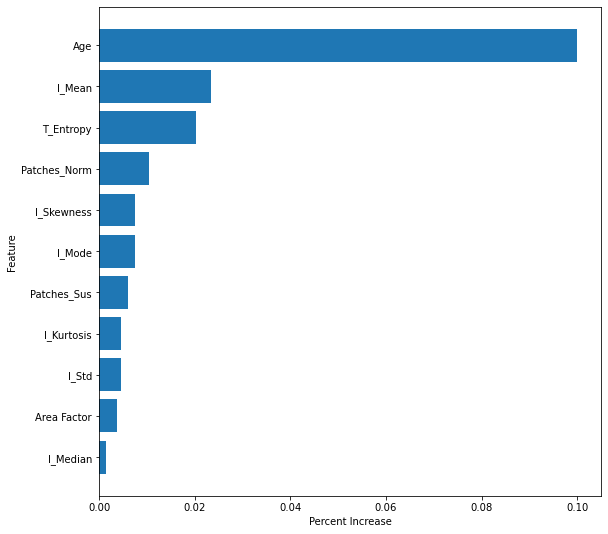

In [22]:
from sklearn.inspection import permutation_importance

result = permutation_importance(forest_model, X_valid, y_valid, n_repeats=10)
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(9,9))
plt.barh(X_train.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel('Percent Increase')
plt.ylabel('Feature')
plt.savefig('patch_RF_fi.pdf')


## Cross Validation

In [23]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

In [ ]:
forest_model = RandomForestClassifier(max_depth=7, n_estimators=500)
#model = svm.SVC()
pipeline = Pipeline(steps=[('model',forest_model)])
#pipeline = Pipeline(steps=[('model',model)])
scores = cross_val_score(pipeline, X, y,cv=5,scoring='roc_auc')
print('AUC: \n',scores)

In [ ]:
pipeline.fit(X_train,y_train)

In [ ]:
y_pred = pipeline.predict_proba(X_valid)

In [ ]:
ypred = []
for i in y_pred:
    if i[0] > 0.5:
        ypred.append(0)
    else:
        ypred.append(1)

In [ ]:
classes = ['Normal','Suspicious']
c = sklearn.metrics.confusion_matrix(y_valid,np.argmax(y_pred,axis=1),normalize='true')
c = np.around(c,decimals =2)

plt.figure(figsize=(6, 6))
plt.imshow(c,cmap='Blues')

plt.xticks(np.arange(len(classes)),classes,rotation=45,rotation_mode="anchor",ha="right")
plt.yticks(np.arange(len(classes)),classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i in range(c.shape[1]):
    for j in range(c.shape[1]):
        if c[i,j]<0.5:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="black",fontsize='large')
        else:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="w",fontsize='large')
#plt.title("Confusion Matrix")
plt.colorbar()
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)
plt.savefig('patch_RF_cm.pdf')
plt.show()

In [ ]:
ypred=[]
for i in y_pred:
    ypred.append(i[1])
auc = sklearn.metrics.roc_auc_score(y_valid,ypred)
fpr,tpr,t= sklearn.metrics.roc_curve(y_valid,ypred)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.plot(fpr,tpr, color='b',
        label=r'ROC (AUC = %0.2f )' % (auc),
        lw=2, alpha=.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.legend(loc="lower right")
plt.savefig('patch_RF_ROC.pdf')
#print('AUC:',auc)

In [ ]:
model = svm.SVC(C=1.75, kernel='linear',probability=True)
pipeline = Pipeline(steps=[('model',model)])
pipeline.fit(X_train,y_train)

In [ ]:
y_pred = pipeline.predict_proba(X_valid)
ypred = []
for i in y_pred:
    if i[0] > 0.5:
        ypred.append(0)
    else:
        ypred.append(1)

In [ ]:
classes = ['Normal','Suspicious']
c = sklearn.metrics.confusion_matrix(y_valid,np.argmax(y_pred,axis=1),normalize='true')
c = np.around(c,decimals =2)

plt.figure(figsize=(5, 5))
plt.imshow(c,cmap='Blues')

plt.xticks(np.arange(len(classes)),classes,rotation=45,rotation_mode="anchor",ha="right")
plt.yticks(np.arange(len(classes)),classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i in range(c.shape[1]):
    for j in range(c.shape[1]):
        if c[i,j]<0.5:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="black",fontsize='large')
        else:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="w",fontsize='large')
#plt.title("Confusion Matrix")
plt.colorbar()
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)
plt.savefig('patch_svm_cm.png')
plt.show()


In [ ]:
ypred=[]
for i in y_pred:
    ypred.append(i[1])
auc = sklearn.metrics.roc_auc_score(y_valid,ypred)
fpr,tpr,t= sklearn.metrics.roc_curve(y_valid,ypred)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.plot(fpr,tpr, color='b',
        label=r'ROC (AUC = %0.2f )' % (auc),
        lw=2, alpha=.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.legend(loc="lower right")
#plt.show()
plt.savefig('patch_svm_ROC.pdf')
#print('AUC:',auc)

In [24]:
forest_model = RandomForestClassifier(max_depth=7, n_estimators=500)
pipeline = Pipeline(steps=[('model',forest_model)])
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict_proba(X_valid)
ypred1=[]
for i in y_pred:
    ypred1.append(i[1])

In [25]:
model = svm.SVC(C=1.75, kernel='linear',probability=True)
pipeline = Pipeline(steps=[('model',model)])
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict_proba(X_valid)
ypred2=[]
for i in y_pred:
    ypred2.append(i[1])

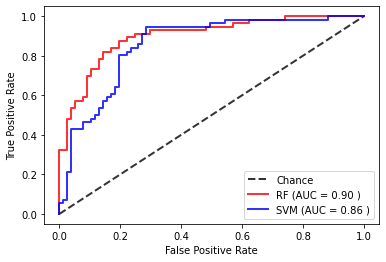

In [32]:
auc1 = sklearn.metrics.roc_auc_score(y_valid,ypred1)
auc2 = sklearn.metrics.roc_auc_score(y_valid,ypred2)
fpr1,tpr1,t= sklearn.metrics.roc_curve(y_valid,ypred1)
fpr2,tpr2,t= sklearn.metrics.roc_curve(y_valid,ypred2)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
        label='Chance', alpha=.8)
ax.plot(fpr1,tpr1, color='r',
        label=r'RF (AUC = %0.2f )' % (auc1),
        lw=2, alpha=.8)
ax.plot(fpr2,tpr2, color='b',
        label=r'SVM (AUC = %0.2f )' % (auc2),
        lw=2, alpha=.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.legend(loc="lower right")
#plt.show()
plt.savefig('patch_ROC.pdf')
#print('AUC:',auc)